Chuẩn bị dữ liệu, kết hợp 3 data lại với nhau

In [2]:
import pandas as pd

DATA_DIR = "recommendation dataset"
item_df    = pd.read_parquet(f"{DATA_DIR}/sales_pers.item_chunk_0.parquet")
user_df    = pd.read_parquet(f"{DATA_DIR}/sales_pers.user_chunk_0.parquet")
history_df = pd.read_parquet(f"{DATA_DIR}/sales_pers.purchase_history_daily_chunk_0.parquet")

merged_df = history_df.merge(item_df, on="item_id", how="left")

merged_df = merged_df.merge(user_df, on="customer_id", how="left")

print("Kích thước dữ liệu cuối:", merged_df.shape)
merged_df.head()


Kích thước dữ liệu cuối: (500000, 66)


,timestamp_x,user_id_x,item_id,event_type,event_value,price_x,date_key,quantity,customer_id,created_date_x,...,sync_status_id_y,last_sync_date_y,sync_error_message_y,region,location_name,install_app,install_date,district,user_id_y,is_deleted
0,1735064221,ca12702ddf55acaa9fb767e10faaa67a9b101e06be6ae2...,7115000000004,Purchase,1.0000,49000.0000,20241224,1,5254214,2024-12-24 18:17:01.027,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1735068481,54314ce86269f4849f9a4c3fc85d94b9ba96cbcba64ce1...,0029130000030,Purchase,1.0000,69000.0000,20241224,1,7573232,2024-12-24 19:28:01.870,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1735069843,4799de4022b58689b2b9fb37122479b1ef448d7b7901a9...,3496000000053,Purchase,2.0000,75000.0000,20241224,2,8187418,2024-12-24 19:50:43.760,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1735069779,4799de4022b58689b2b9fb37122479b1ef448d7b7901a9...,2700000000002,Purchase,2.0000,58500.0000,20241224,2,8187418,2024-12-24 19:49:39.223,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1735379373,3b2423f730815273dfd6f6220b0c5c072d6aab08f9da9b...,0029110000036,Purchase,1.0000,89000.0000,20241228,1,6931560,2024-12-28 09:49:33.780,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Thống kê mô tả cơ bản cho các biến chính


In [4]:
print(merged_df[['event_value', 'quantity', 'price_x']].describe())
print(merged_df[['gender', 'payment', 'channel']].value_counts())


            quantity
count  500000.000000
mean        1.495030
std         2.135368
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       168.000000
gender  payment         channel       
Nữ      Tiền mặt        In-Store          35292
        VietQR          In-Store          16579
        Cà thẻ          In-Store          10511
Nam     Tiền mặt        In-Store           6315
Nữ      VNPay           In-Store           2960
Nam     VietQR          In-Store           2294
Nữ      Tiền mặt        iOS                2031
Nam     Cà thẻ          In-Store           1760
Nữ      MoMo            In-Store            931
        Không xác định  SPE                 886
        Tiền mặt        SPE                 615
                        Android             612
        MoMo            iOS                 458
        Cà thẻ          iOS                 447
Nam     VNPay           In-Store            403
Nữ      ZaloPay         iOS                 384
    

Nhận xét:

- Dữ liệu quantity cực kỳ lệch phải (right-skewed): phần lớn khách hàng chỉ mua 1 sản phẩm mỗi lần, nhưng có một số ít giao dịch lớn kéo trung bình lên gần 1.5.
- Điều này cho thấy hành vi mua hàng là mua đơn lẻ, chỉ một tỷ lệ rất nhỏ có hành vi mua sỉ / giỏ hàng lớn.
- Nữ giới là nhóm chiếm tỷ trọng giao dịch cao nhất, đặc biệt là khi mua trực tiếp tại cửa hàng (In-Store) và thanh toán bằng tiền mặt (≈ 35 292 giao dịch).
- Hình thức thanh toán VietQR và Cà thẻ cũng được sử dụng khá nhiều, chủ yếu bởi nữ.
- Nam giới cũng có giao dịch nhưng thấp hơn đáng kể so với nữ (~6.315 giao dịch tiền mặt tại cửa hàng).
- Kênh In-Store chiếm áp đảo → cho thấy khách hàng vẫn ưu tiên mua trực tiếp, trong khi các nền tảng iOS / Android / SPE có số lượng rất thấp.
- Có vài hình thức thanh toán rất hiếm (1–2 giao dịch) như ShopeePay, điều này gợi ý cần kiểm tra dữ liệu lỗi hoặc hiếm gặp.

TRỰC QUAN HÓA DỮ LIỆU:

Phân tích dạng số – số

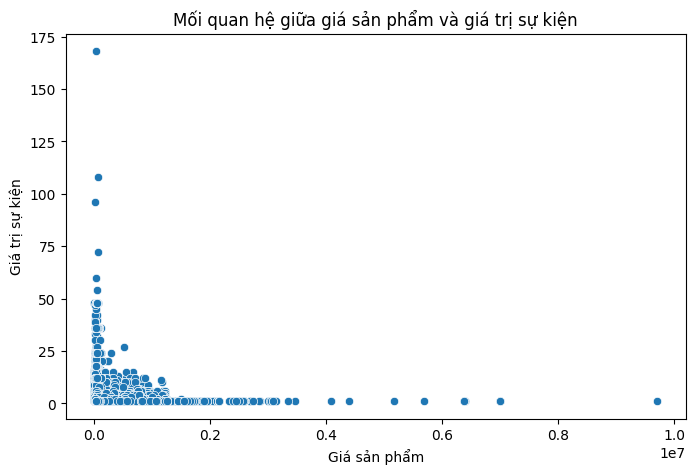

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.scatterplot(data=merged_df, x='price_x', y='event_value')
plt.title("Mối quan hệ giữa giá sản phẩm và giá trị sự kiện")
plt.xlabel("Giá sản phẩm")
plt.ylabel("Giá trị sự kiện")
plt.show()


- Phần lớn các giao dịch diễn ra ở mức giá thấp và giá trị sự kiện nhỏ → thể hiện hành vi mua lẻ, giá trị thấp là chủ yếu.

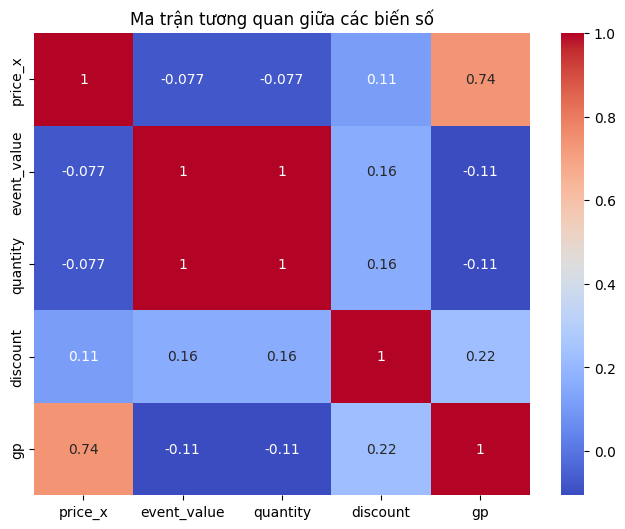

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(merged_df[['price_x','event_value','quantity','discount','gp']].corr(), 
            annot=True, cmap='coolwarm')
plt.title("Ma trận tương quan giữa các biến số")
plt.show()


- Giá sản phẩm (price_x) và lợi nhuận (gp) có mối tương quan mạnh (0.74) → Đây là mối quan hệ quan trọng, gợi ý rằng chiến lược định giá có tác động lớn đến lợi nhuận.
- event_value và quantity gần như trùng nhau (hệ số = 1) → Điều này xác nhận lại rằng tổng giá trị giao dịch chủ yếu phụ thuộc vào số lượng bán.
- price_x không liên hệ rõ rệt với quantity hoặc event_value → giá cao không làm giảm số lượng bán ra rõ rệt, có thể vì khách hàng không quá nhạy cảm với giá hoặc sản phẩm thuộc nhóm cần thiết.
- discount có tương quan yếu với các biến khác → khuyến mãi có ảnh hưởng tích cực nhưng không mạnh đến lợi nhuận và doanh thu.
- Có dấu hiệu tương quan âm nhẹ giữa gp và quantity / event_value → có thể do bán nhiều hàng đi kèm chiết khấu cao làm giảm lợi nhuận.

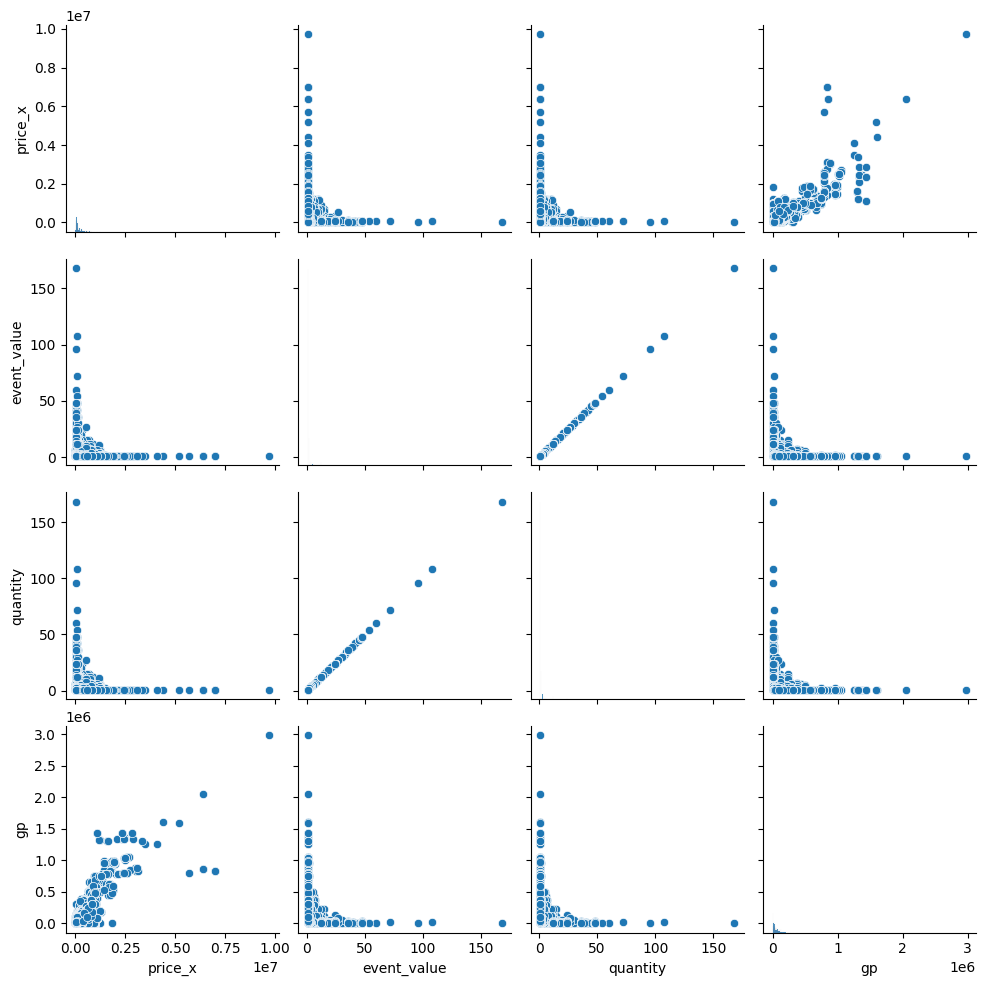

In [10]:
sns.pairplot(merged_df[['price_x','event_value','quantity','gp']])
plt.show()


- event_value phụ thuộc rất mạnh vào số lượng mua (quantity) – điều này hoàn toàn hợp lý trong kinh doanh.
- Giá sản phẩm (price_x) không quyết định số lượng bán ra, gợi ý rằng hành vi mua hàng không chỉ phụ thuộc vào giá.
- Có một số giao dịch bất thường (outlier) cần xem xét kỹ hơn trong phân tích sâu.
- Cấu trúc phân bố lệch → khi phân tích thêm có thể cân nhắc dùng log scale hoặc chuẩn hóa dữ liệu để biểu đồ rõ hơn.

Phân tích dạng số – phân loại

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", font_scale=1.05)

# Chọn cột price dùng để vẽ
price_col = 'price_x' if 'price_x' in merged_df.columns else 'price'

# Ép kiểu số và làm sạch nhanh
def to_num(s):
    s = pd.to_numeric(s, errors='coerce')
    return s.fillna(0).clip(lower=0)

h = merged_df.copy()
h[price_col] = to_num(h[price_col])


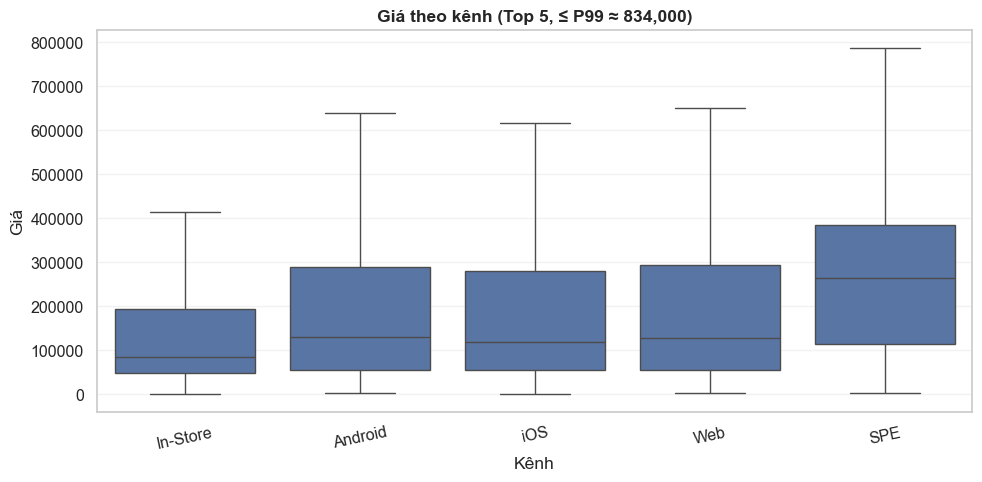

In [26]:
# Top kênh
top_channels = h['channel'].value_counts().head(5).index
df1 = h[h['channel'].isin(top_channels)].copy()

# Zoom P99 để bớt outlier
p99 = df1[price_col].quantile(0.99)
df1 = df1[df1[price_col] <= p99]

plt.figure(figsize=(10,5))
sns.boxplot(data=df1, x='channel', y=price_col, showfliers=False)
plt.title(f'Giá theo kênh (Top 5, ≤ P99 ≈ {p99:,.0f})', weight='bold')
plt.xlabel('Kênh'); plt.ylabel('Giá')
plt.xticks(rotation=12)
plt.grid(axis='y', alpha=0.25)
plt.tight_layout(); plt.show()


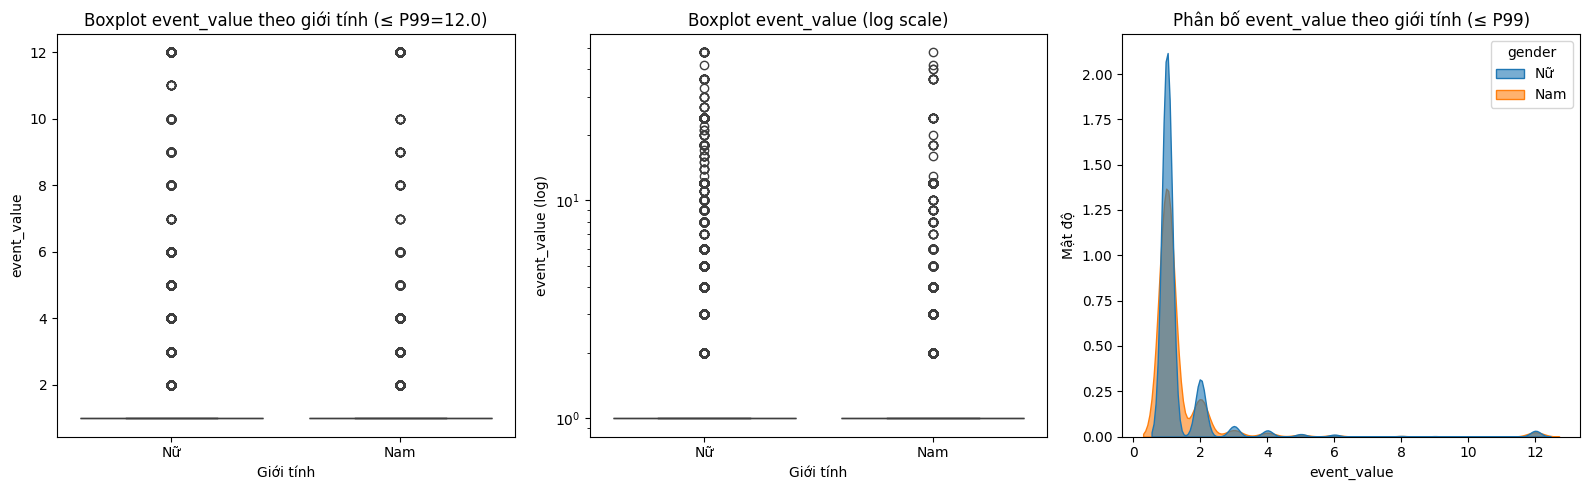

In [ ]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

df = merged_df.copy()
df['event_value'] = pd.to_numeric(df['event_value'], errors='coerce').clip(lower=0)
df = df.dropna(subset=['gender','event_value'])
p99 = df['event_value'].quantile(0.99)

fig, axes = plt.subplots(1, 3, figsize=(16,5))

sns.boxplot(ax=axes[0], data=df[df['event_value'] <= p99], x='gender', y='event_value')
axes[0].set_title(f'Boxplot event_value theo giới tính (≤ P99={p99:.1f})')
axes[0].set_xlabel('Giới tính'); axes[0].set_ylabel('event_value')

sns.boxplot(ax=axes[1], data=df, x='gender', y='event_value')
axes[1].set_yscale('log')
axes[1].set_title('Boxplot event_value (log scale)')
axes[1].set_xlabel('Giới tính'); axes[1].set_ylabel('event_value (log)')

sns.kdeplot(ax=axes[2], data=df[df['event_value'] <= p99], x='event_value',
            hue='gender', fill=True, common_norm=False, alpha=0.6)
axes[2].set_title('Phân bố event_value theo giới tính (≤ P99)')
axes[2].set_xlabel('event_value'); axes[2].set_ylabel('Mật độ')

plt.tight_layout(); plt.show()


Qua ba biểu đồ trực quan, có thể thấy giá trị sự kiện (event_value) của cả hai giới tính đều tập trung chủ yếu ở mức thấp (dưới 2 đơn vị), phản ánh rằng phần lớn các giao dịch có giá trị nhỏ. Sự xuất hiện của một số điểm ngoại lệ cho thấy có một số giao dịch giá trị cao hơn đáng kể so với trung bình. Khi xét toàn bộ dữ liệu theo thang log, phân bố vẫn lệch phải mạnh và không có sự khác biệt đáng kể giữa nam và nữ. Biểu đồ mật độ cũng khẳng định hai giới có hành vi chi tiêu tương đồng, với đỉnh phân bố gần như trùng nhau quanh giá trị thấp.

C:\Users\DELL\AppData\Local\Temp\ipykernel_10040\3602216409.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Hình thức thanh toán', bbox_to_anchor=(1.02,1), loc='upper left', frameon=True)


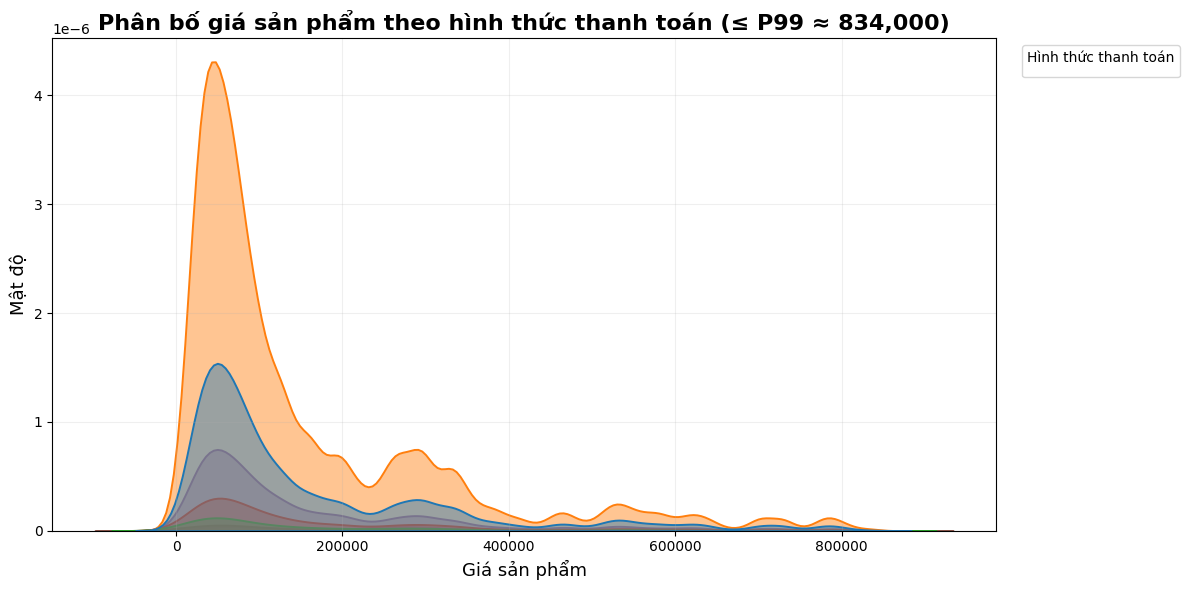

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Chuẩn hóa dữ liệu giá
s = pd.to_numeric(merged_df['price_x'], errors='coerce')  # Decimal/str -> float
s = s.fillna(0).clip(lower=0)                             # bỏ NaN, chặn âm

# 2) Tạo dataframe vẽ + tính P99 để zoom
df_plot = merged_df.copy()
df_plot['price_x_num'] = s
p99 = df_plot['price_x_num'].quantile(0.99)
df_plot = df_plot[df_plot['price_x_num'] <= p99]

# 3) Gộp các payment hiếm thành "Khác" để biểu đồ bớt rối
top_methods = df_plot['payment'].value_counts().head(6).index
df_plot['payment_top'] = np.where(df_plot['payment'].isin(top_methods),
                                  df_plot['payment'], 'Khác')

# 4) Vẽ KDE đẹp, legend ngoài, lưới nhẹ
plt.figure(figsize=(12,6))
sns.kdeplot(
    data=df_plot,
    x='price_x_num',
    hue='payment_top',
    fill=True,
    alpha=0.45,
    linewidth=1.4
)
plt.title(f'Phân bố giá sản phẩm theo hình thức thanh toán (≤ P99 ≈ {p99:,.0f})', fontsize=16, weight='bold')
plt.xlabel('Giá sản phẩm', fontsize=13)
plt.ylabel('Mật độ', fontsize=13)
plt.grid(alpha=0.2)
plt.legend(title='Hình thức thanh toán', bbox_to_anchor=(1.02,1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()


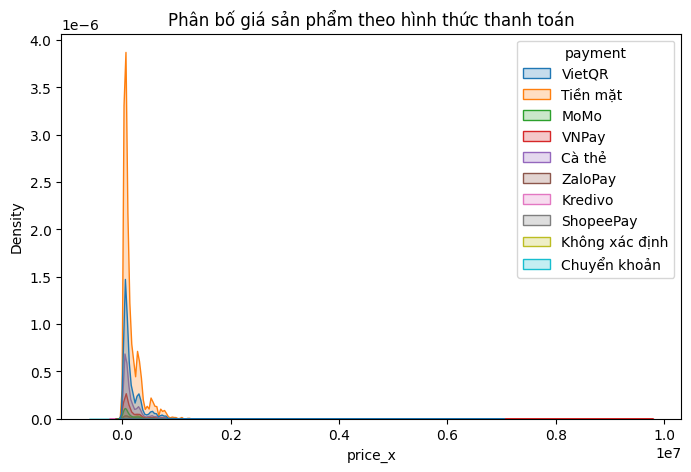

In [13]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=merged_df, x='price_x', hue='payment', fill=True)
plt.title("Phân bố giá sản phẩm theo hình thức thanh toán")
plt.show()


Biểu đồ mật độ cho thấy phân bố giá sản phẩm theo hình thức thanh toán đều tập trung chủ yếu ở mức giá thấp, thể hiện sự lệch phải rõ rệt. Trong đó, phương thức “Tiền mặt” chiếm ưu thế vượt trội so với các hình thức khác, đặc biệt là ở nhóm sản phẩm giá trị thấp. “VietQR” đứng thứ hai nhưng vẫn ở mức thấp hơn nhiều, trong khi các phương thức ví điện tử và thẻ ngân hàng có tỷ lệ sử dụng hạn chế. Không có sự khác biệt đáng kể về khoảng giá giữa các phương thức thanh toán, cho thấy yếu tố giá không ảnh hưởng nhiều đến lựa chọn phương thức thanh toán của khách hàng.

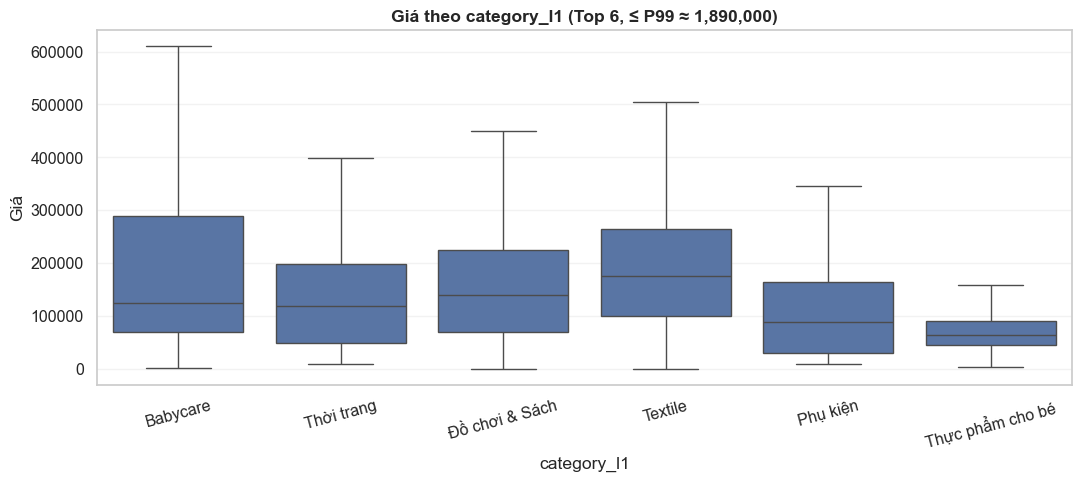

In [29]:
i = (item_df_fix if 'item_df_fix' in globals() else item_df).copy()
i['price'] = to_num(i['price'])
top_c1 = i['category_l1'].value_counts().head(6).index
ii = i[i['category_l1'].isin(top_c1)].copy()

p99_i = ii['price'].quantile(0.99)
ii = ii[ii['price'] <= p99_i]

plt.figure(figsize=(11,5))
sns.boxplot(data=ii, x='category_l1', y='price', showfliers=False)
plt.title(f'Giá theo category_l1 (Top 6, ≤ P99 ≈ {p99_i:,.0f})', weight='bold')
plt.xlabel('category_l1'); plt.ylabel('Giá')
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.25)
plt.tight_layout(); plt.show()


- Do giá sản phẩm trong từng danh mục chênh lệch đáng kể, nên các chiến dịch tiếp thị có thể chia theo phân khúc giá (bình dân – trung cấp – cao cấp).
- Nhóm Babycare và Textile nên được chú trọng trong chính sách giá linh hoạt, trong khi nhóm Thực phẩm cho bé có thể tập trung vào chiến lược số lượng lớn – giá rẻ.

Phân tích dạng phân loại – phân loại

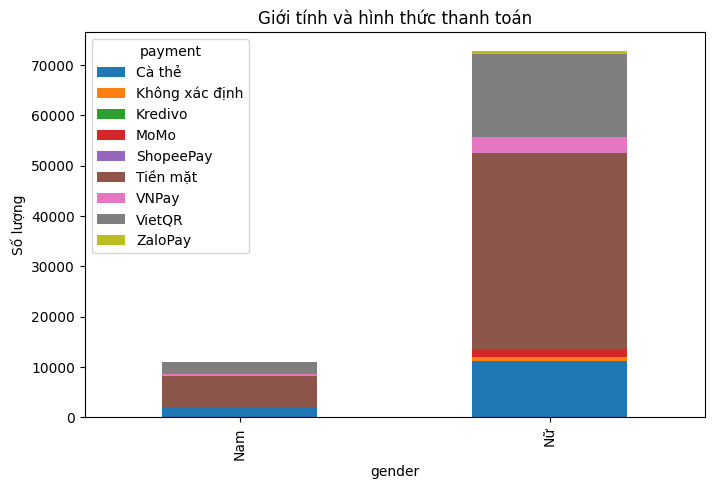

In [14]:
pd.crosstab(merged_df['gender'], merged_df['payment']).plot(kind='bar', stacked=True, figsize=(8,5))
plt.title("Giới tính và hình thức thanh toán")
plt.ylabel("Số lượng")
plt.show()


Biểu đồ cột xếp chồng cho thấy nhóm khách hàng nữ chiếm tỷ trọng áp đảo về số lượng giao dịch so với nam, chứng tỏ họ là nhóm khách hàng chính của hệ thống. Hình thức thanh toán tiền mặt vẫn chiếm ưu thế lớn ở cả hai giới, trong khi các phương thức thanh toán điện tử như VietQR và Cà thẻ đứng ở vị trí tiếp theo. Mặc dù ví điện tử và các hình thức thanh toán số khác đã xuất hiện, mức độ phổ biến của chúng vẫn còn hạn chế. Ngoài ra, khách hàng nữ không chỉ có số lượng giao dịch lớn hơn mà còn có xu hướng sử dụng nhiều phương thức thanh toán đa dạng hơn so với nam giới.

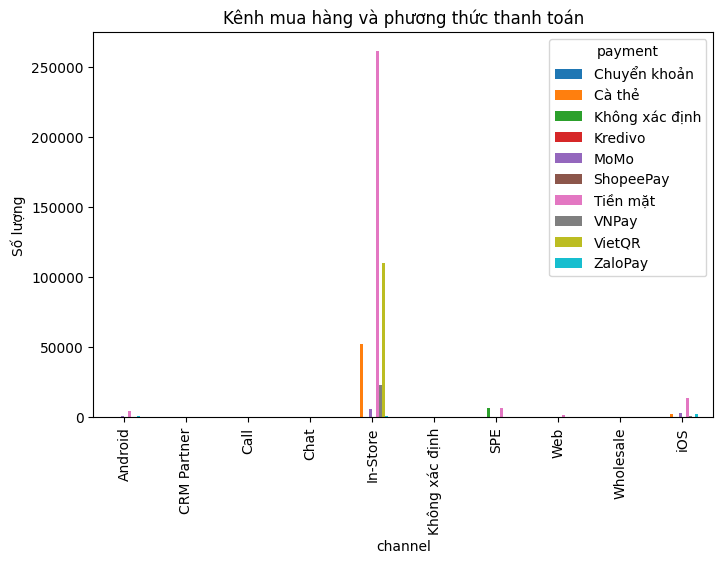

In [15]:
pd.crosstab(merged_df['channel'], merged_df['payment']).plot(kind='bar', figsize=(8,5))
plt.title("Kênh mua hàng và phương thức thanh toán")
plt.ylabel("Số lượng")
plt.show()


Biểu đồ cho thấy phần lớn giao dịch tập trung tại kênh mua hàng trực tiếp (In-Store), chiếm áp đảo so với tất cả các kênh còn lại. Điều này khẳng định vai trò chủ đạo của cửa hàng vật lý trong hoạt động kinh doanh. Hình thức thanh toán tiền mặt và VietQR chiếm ưu thế tại In-Store, trong khi các phương thức điện tử như MoMo, VNPay, ShopeePay… tuy đã xuất hiện nhưng chủ yếu ở các kênh online với số lượng giao dịch còn thấp. Các kênh như Web, Android hay CRM Partner có tỷ trọng giao dịch không đáng kể, cho thấy tiềm năng phát triển vẫn còn rất lớn nếu được đầu tư và quảng bá đúng cách.

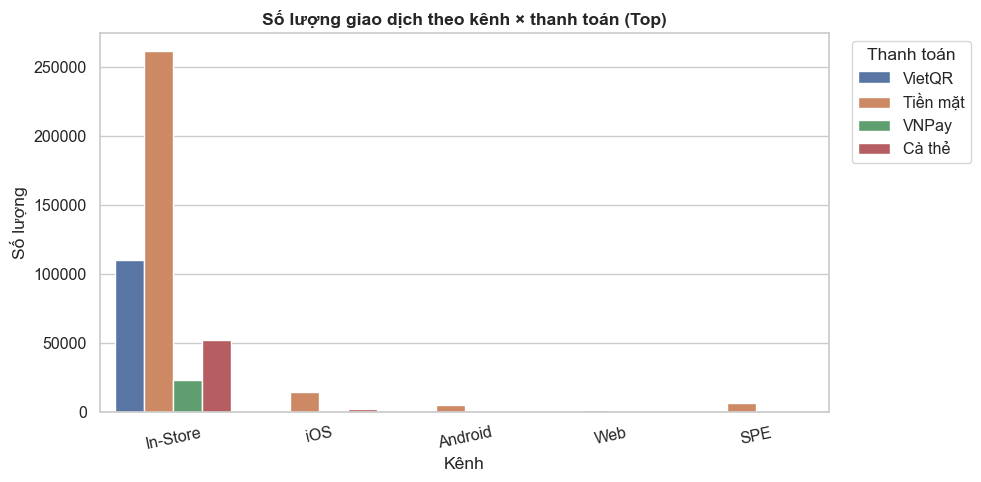

In [27]:
top_x   = h['channel'].value_counts().head(5).index
top_hue = h['payment'].value_counts().head(4).index
df2 = h[h['channel'].isin(top_x) & h['payment'].isin(top_hue)]

plt.figure(figsize=(10,5))
sns.countplot(data=df2, x='channel', hue='payment')
plt.title('Số lượng giao dịch theo kênh × thanh toán (Top)', weight='bold')
plt.xlabel('Kênh'); plt.ylabel('Số lượng')
plt.xticks(rotation=12)
plt.legend(title='Thanh toán', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout(); plt.show()


1. In-Store áp đảo tuyệt đối.
- Tiền mặt lớn nhất (≈ 260k giao dịch).
- VietQR đứng thứ hai (≈ 110k).
- Cà thẻ tiếp theo (≈ 50k).
- VNPay nhỏ hơn (≈ 20–25k).
2. Kênh online rất nhỏ so với In-Store:
- iOS chỉ ~10–15k (chủ yếu Tiền mặt/VietQR giao nhận tại quầy).
- Android vài nghìn.
- SPE vài nghìn.
- Web gần như không đáng kể.
- => Cơ cấu phương thức tương đối giống nhau giữa các kênh nhỏ: Tiền mặt vẫn chiếm chính, VietQR có mặt nhưng ít; ví/điện tử (VNPay) ở mức rất thấp.

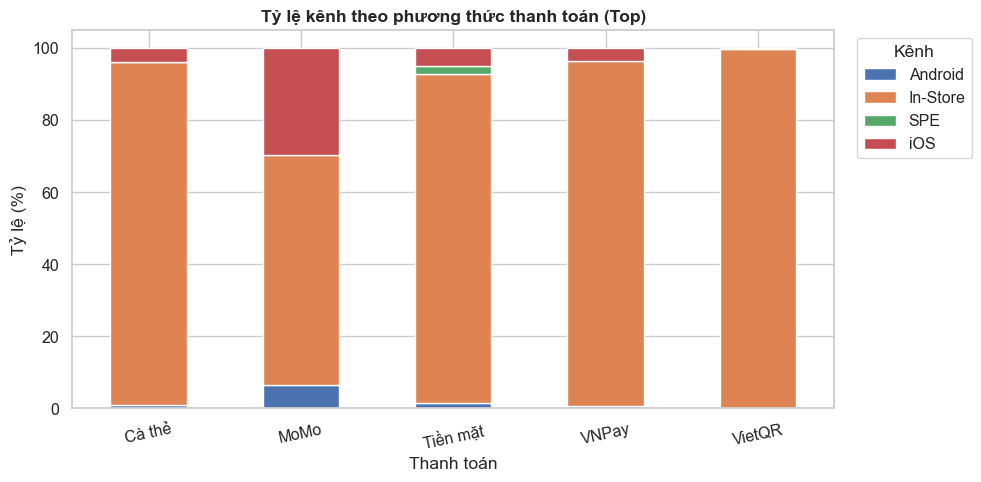

In [28]:
top_pay = h['payment'].value_counts().head(5).index
top_chan = h['channel'].value_counts().head(4).index
df3 = h[h['payment'].isin(top_pay) & h['channel'].isin(top_chan)]

ctab = (df3
        .pivot_table(index='payment', columns='channel', values='item_id',
                     aggfunc='count', fill_value=0))
ctab_pct = ctab.div(ctab.sum(axis=1), axis=0) * 100

ax = ctab_pct.plot(kind='bar', stacked=True, figsize=(10,5))
plt.ylabel('Tỷ lệ (%)'); plt.xlabel('Thanh toán')
plt.title('Tỷ lệ kênh theo phương thức thanh toán (Top)', weight='bold')
plt.legend(title='Kênh', bbox_to_anchor=(1.02,1), loc='upper left')
plt.xticks(rotation=12)
plt.tight_layout(); plt.show()


Trọng tâm thanh toán vẫn ở cửa hàng vật lý; các kênh online đóng góp rất nhỏ.

Phân tích đa biến

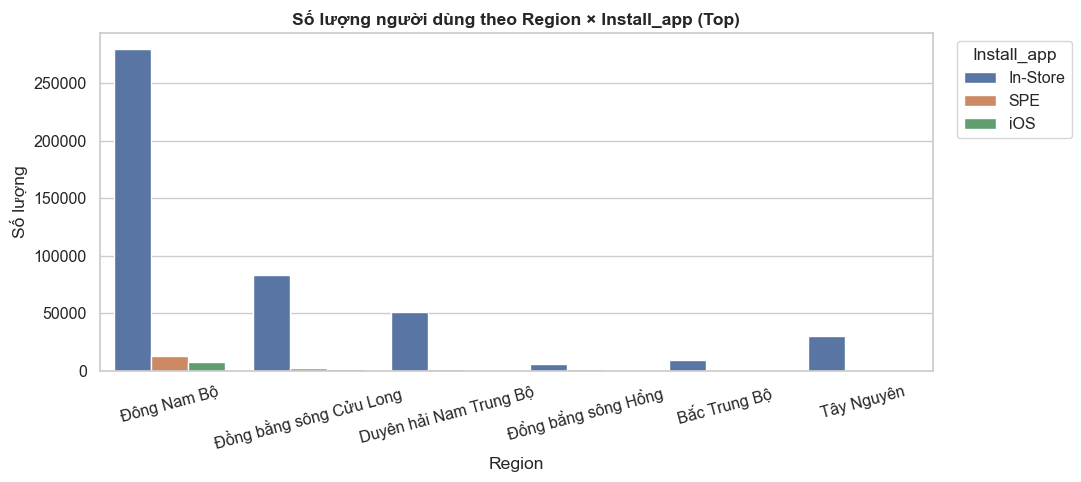

In [31]:
u = (user_df_fix if 'user_df_fix' in globals() else user_df).copy()
top_r = u['region'].value_counts().head(6).index
top_app = u['install_app'].value_counts().head(3).index
uu = u[u['region'].isin(top_r) & u['install_app'].isin(top_app)]

plt.figure(figsize=(11,5))
sns.countplot(data=uu, x='region', hue='install_app')
plt.title('Số lượng người dùng theo Region × Install_app (Top)', weight='bold')
plt.xlabel('Region'); plt.ylabel('Số lượng')
plt.xticks(rotation=15)
plt.legend(title='Install_app', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout(); plt.show()


- Đông Nam Bộ vượt trội (≈ vài trăm nghìn In-Store) → thị trường cốt lõi.
- Nhóm kế tiếp: ĐBS Cửu Long (~trăm nghìn), rồi Duyên hải Nam Trung Bộ (~vài chục nghìn).
- Các vùng ĐBS Sông Hồng, Bắc Trung Bộ, Tây Nguyên thấp hơn đáng kể.
- Trong mọi vùng, In-Store áp đảo; SPE và iOS chỉ chiếm tỷ lệ nhỏ, cao nhất vẫn ở Đông Nam Bộ.

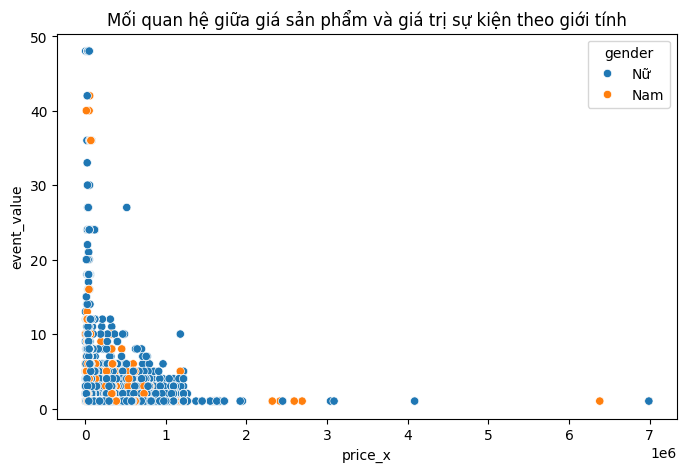

In [18]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=merged_df, x='price_x', y='event_value', hue='gender')
plt.title("Mối quan hệ giữa giá sản phẩm và giá trị sự kiện theo giới tính")
plt.show()


Biểu đồ cho thấy rằng phần lớn các giao dịch có giá sản phẩm thấp và giá trị sự kiện nhỏ, với sự phân bố tương tự giữa khách hàng nam và nữ. Giới tính dường như không ảnh hưởng nhiều đến mối quan hệ giữa hai biến này. Tuy nhiên, vẫn tồn tại một số điểm ngoại lệ có giá sản phẩm cao nhưng giá trị sự kiện thấp, gợi ý rằng cần phân tích sâu hơn các nhóm sản phẩm cao cấp hoặc các sự kiện đặc thù.

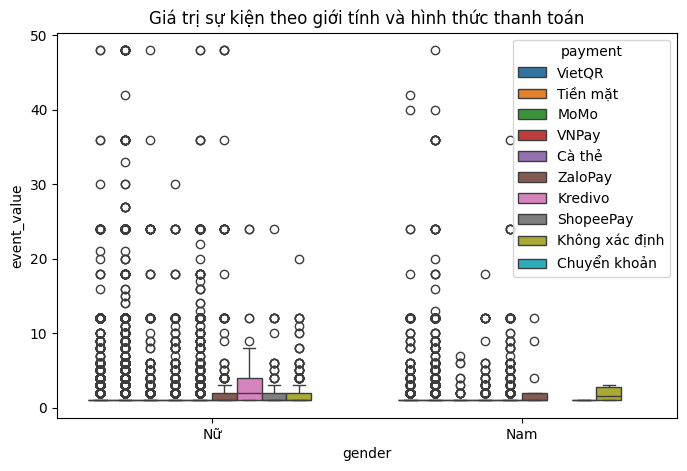

In [21]:
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_df, x='gender', y='event_value', hue='payment')
plt.title("Giá trị sự kiện theo giới tính và hình thức thanh toán")
plt.show()


- Biểu đồ cho thấy giá trị sự kiện nhìn chung thấp (< 10) ở cả hai giới, nhưng có một số outliers vượt trội thể hiện những sự kiện đặc biệt.
- Khách hàng nữ có xu hướng tham gia nhiều sự kiện hơn và sử dụng nhiều phương thức thanh toán hơn so với nam.
- Một số hình thức thanh toán như VietQR, Tiền mặt liên quan đến các sự kiện có giá trị cao hơn.
- Cần chú ý đến các điểm "Không xác định", vì chúng có thể là dữ liệu chưa sạch hoặc phản ánh nhóm khách hàng đặc biệt.